### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pydicom as dcm
import os

os.chdir(r'C:\Users\sriva\Desktop\Pneumonia_Detection')

### Data Preprocessing

In [2]:
class_info_data = pd.read_csv('stage_2_detailed_class_info.csv')
print(class_info_data.shape)
class_info_data.head()

(30227, 2)


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [3]:
train_labels_data = pd.read_csv('stage_2_train_labels.csv')
print(train_labels_data.shape)
train_labels_data.head()

(30227, 6)


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

### Data Exploration

##### Missing data

In [4]:
def findMissingData(df):
    total_missing_data = df.isna().sum().sort_values(ascending=False)
    percent_missing_data = (df.isna().sum()/df.isna().count()*100).sort_values(ascending=False)
    target_df = pd.concat([total_missing_data, percent_missing_data], axis=1, keys=['Total', 'Percentage'])
    target_df = np.transpose(target_df)
    return target_df

In [5]:
findMissingData(class_info_data)

class  patientId
Total         0.0        0.0
Percentage    0.0        0.0

In [6]:
findMissingData(train_labels_data)

height         width             y             x  Target  \
Total       20672.000000  20672.000000  20672.000000  20672.000000     0.0   
Percentage     68.389188     68.389188     68.389188     68.389188     0.0   

            patientId  
Total             0.0  
Percentage        0.0

In [7]:
distribution_data = pd.DataFrame(class_info_data['class'].value_counts()).reset_index()
distribution_data.columns = ['Class', 'Count']
distribution_data['Percentage'] = [round(distribution_data.loc[i, 'Count']/distribution_data['Count'].sum()*100, 2) for i in distribution_data.index]
distribution_data

Class  Count  Percentage
0  No Lung Opacity / Not Normal  11821       39.11
1                  Lung Opacity   9555       31.61
2                        Normal   8851       29.28

In [8]:
distribution_data['Count'].sum()

30227

### Data Exploration

##### Distribution of various classes of observations

In [9]:
fig = px.bar(distribution_data, x='Class', text='Percentage', y='Percentage', color='Class')
fig.show()

In [10]:
train_data = train_labels_data.merge(class_info_data, left_on='patientId', right_on='patientId', how='inner')
train_data.head(10)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
6  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
7  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
8  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0   
9  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  
5                  Lung Opacity  
6                  Lung Opacity  
7                  Lung Opacity  
8  No Lung Opacity / Not Normal  
9  No Lung Opacity / Not Normal

In [11]:
train_data.groupby('Target')['class'].value_counts()

Target  class                       
0       No Lung Opacity / Not Normal    11821
        Normal                           8851
1       Lung Opacity                    16957
Name: class, dtype: int64

In [12]:
target_distribution = pd.DataFrame(data=train_data.groupby('Target')['class'].value_counts().values, index=train_data.groupby('Target')['class'].value_counts().index).reset_index()
target_distribution.columns = ['target', 'class', 'count']
target_distribution

target                         class  count
0       0  No Lung Opacity / Not Normal  11821
1       0                        Normal   8851
2       1                  Lung Opacity  16957

We can observe that all observations with target = 1 are associated with lung opacities.

##### Detecting lung opacity window

For the class lung opacity, corresponding to target = 1, we plot the density of x, y, width and height.

In [13]:
target_dataset = train_data[train_data['Target']==1]
target_dataset.shape

(16957, 7)

In [14]:
target_dataset.head()

patientId      x      y  width  height  Target  \
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
6   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
7   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
10  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   

           class  
4   Lung Opacity  
5   Lung Opacity  
6   Lung Opacity  
7   Lung Opacity  
10  Lung Opacity

In [15]:
target_dataset.isna().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
class        0
dtype: int64

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=2)
fig.add_trace(go.Histogram(x=target_dataset['x'], name='x'), row=1, col=1)
fig.add_trace(go.Histogram(x=target_dataset['y'], name='y'), row=1, col=2)
fig.add_trace(go.Histogram(x=target_dataset['width'], name='width'), row=2, col=1)
fig.add_trace(go.Histogram(x=target_dataset['height'], name='height'), row=2, col=2)
fig.show()

In [17]:
target_sample = target_dataset.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width']/2
target_sample['yc'] = target_sample['y'] + target_sample['height']/2

In [18]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=target_sample['xc'], y=target_sample['yc'], mode='markers'))
fig.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=min(target_sample['xc']),
            y0=min(target_sample['yc']),
            x1=500,
            y1=max(target_sample['yc']),
            opacity=0.2,
            fillcolor="yellow",
            line_color="yellow",
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=550,
            y0=min(target_sample['yc']),
            x1=max(target_sample['xc']),
            y1=max(target_sample['yc']),
            opacity=0.2,
            fillcolor="yellow",
            line_color="yellow",
        )])
fig.show()

##### DICOM Data Exploration

In [19]:
train_image_path = os.listdir('stage_2_train_images')
test_image_path = os.listdir('stage_2_test_images')
print('Number of images in the train set:', len(train_image_path))
print('Number of images in the test set:', len(test_image_path))

Number of images in the train set: 26684
Number of images in the test set: 3000


In [20]:
print('Number of unique patient ids in train set:', train_data['patientId'].nunique())

Number of unique patient ids in train set: 26684


We can see that the number of unique patient ids is equal to the number of images in the training set

In [21]:
temp = train_data.groupby(['patientId', 'Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'exams': temp.values}, index=temp.index).reset_index()
df.head()

patientId  Target                         class  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0  No Lung Opacity / Not Normal   
1  000924cf-0f8d-42bd-9158-1af53881a557       0                        Normal   
2  000db696-cf54-4385-b10b-6b16fbb3f985       1                  Lung Opacity   
3  000fe35a-2649-43d4-b027-e67796d412e0       1                  Lung Opacity   
4  001031d9-f904-4a23-b3e5-2c088acd19c6       1                  Lung Opacity   

   exams  
0      1  
1      1  
2      4  
3      4  
4      4

In [22]:
temp2 = df.groupby(['exams', 'Target', 'class']).count()
df2 = pd.DataFrame(data=temp2.values, index=temp2.index).reset_index()
df2.columns = ['exams', 'target', 'class', 'entries']
df2

exams  target                         class  entries
0      1       0  No Lung Opacity / Not Normal    11821
1      1       0                        Normal     8851
2      1       1                  Lung Opacity     2614
3      4       1                  Lung Opacity     3266
4      9       1                  Lung Opacity      119
5     16       1                  Lung Opacity       13

In [23]:
fig = px.bar(df2, x='target', y='entries', color='exams')
fig.show()

We can observe that as the number of exams increase the more number of lung opacities are detected.

##### DICOM metadata processing

In [24]:
np.random.seed(95)
sample_patientId = train_data.loc[np.random.randint(0, len(target_dataset), 1), 'patientId'].values[0]
sample_patientId = sample_patientId + '.dcm'
dicom_file_path = os.path.join('stage_2_train_images/', sample_patientId)
dicom_file = dcm.read_file(dicom_file_path)
dicom_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.18237.1517874409.393461
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.18237.1517874409.393461
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

##### Plotting DICOM images with target = 1

In [25]:
def showDicomImages(df):
    fig, ax = plt.subplots(3, 3, figsize=(16, 18))
    for i in df.index:
        patient_image = df.loc[i, 'patientId'] + '.dcm'
        image_path = os.path.join('stage_2_train_images', patient_image)
        image_data = dcm.read_file(image_path)
        modality = image_data.Modality
        age = image_data.PatientAge
        sex = image_data.PatientSex
        image = dcm.dcmread(image_path)
        ax[i//3, i%3].imshow(image.pixel_array, cmap=plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                                 df.loc[i, 'patientId'], modality, age, sex, df.loc[i, 'Target'], df.loc[i, 'class'], df.loc[i, 'x'],
                                 df.loc[i, 'y'], df.loc[i, 'width'], df.loc[i, 'height']))
    plt.show()

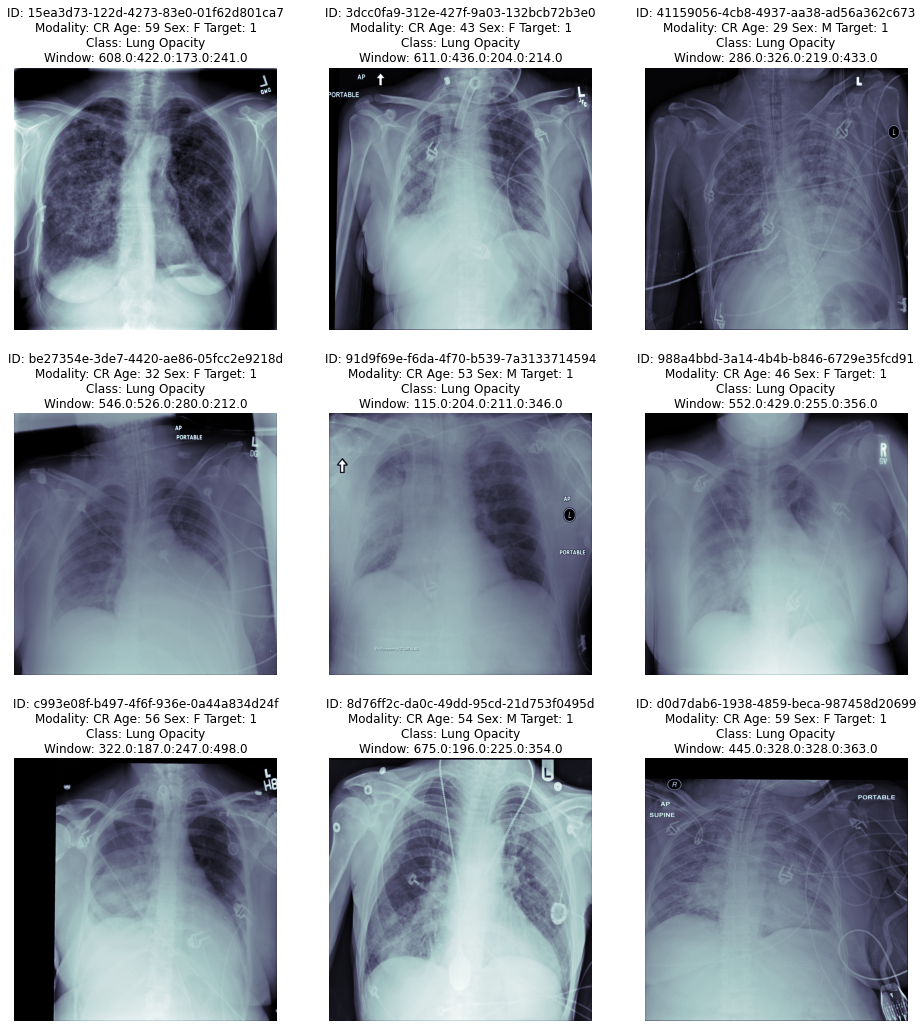

In [26]:
np.random.seed(95)
sample_image_data = target_dataset.sample(9).reset_index().drop(['index'], axis=1)
showDicomImages(sample_image_data)

In [27]:
from matplotlib.patches import Rectangle

def showDicomImagesWithBoxes(df):
    fig, ax = plt.subplots(3, 3, figsize=(16, 18))
    for i in df.index:
        patient_id = df.loc[i, 'patientId']
        patient_image = patient_id + '.dcm'
        image_path = os.path.join('stage_2_train_images', patient_image)
        image_data = dcm.read_file(image_path)
        modality = image_data.Modality
        age = image_data.PatientAge
        sex = image_data.PatientSex
        image = dcm.dcmread(image_path)
        ax[i//3, i%3].imshow(image.pixel_array, cmap=plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                                 patient_id, modality, age, sex, df.loc[i, 'Target'], df.loc[i, 'class'], df.loc[i, 'x'],
                                 df.loc[i, 'y'], df.loc[i, 'width'], df.loc[i, 'height']))
        box_data = train_data[train_data['patientId']==patient_id]
        for j in box_data.index:
            ax[i//3, i%3].add_patch(Rectangle(xy=(box_data.loc[j, 'x'], box_data.loc[j, 'y']), width=box_data.loc[j, 'width'],
                                             height=box_data.loc[j, 'height'], color='yellow', alpha=0.1))
    plt.show()

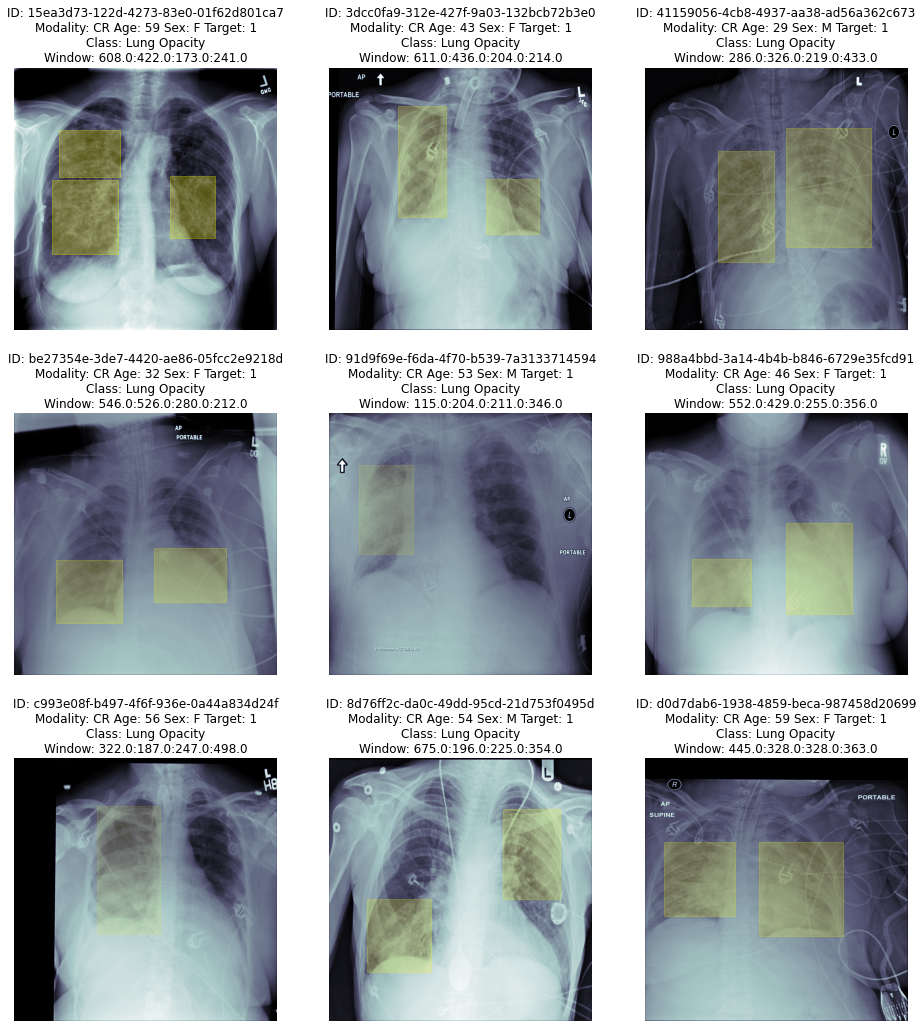

In [28]:
showDicomImagesWithBoxes(sample_image_data)

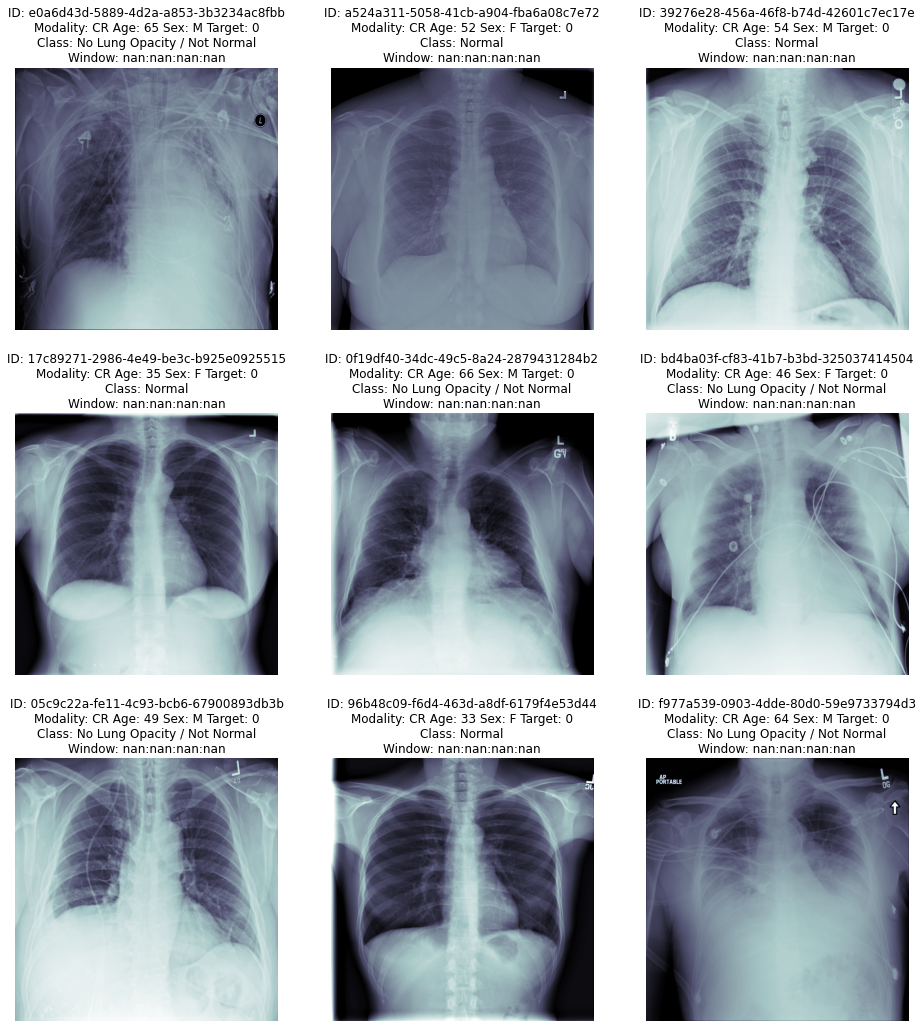

In [29]:
showDicomImagesWithBoxes(train_data[train_data['Target']==0].sample(9).reset_index().drop(['index'], axis=1))

### Data Manipulation

##### Add meta information from DICOM data in the train and test datasets

In [30]:
def addDicomMetaData(df, img_path):
    for img_name in os.listdir(img_path):
#         print(img_name)
        img_data = dcm.read_file(os.path.join(img_path, img_name))
#         print(img_data.PatientId)
        index = (df['patientId']==img_data.PatientID)
        df.loc[index, 'modality'] = img_data.Modality
        df.loc[index, 'patientAge'] = img_data.PatientAge
        df.loc[index, 'patientSex'] = img_data.PatientSex
        df.loc[index, 'bodyPartExamined'] = img_data.BodyPartExamined
        df.loc[index, 'viewPosition'] = img_data.ViewPosition
        df.loc[index, 'conversionType'] = img_data.ConversionType
        df.loc[index, 'rows'] = img_data.Rows
        df.loc[index, 'columns'] = img_data.Columns
        df.loc[index, 'pixelSpacing'] = str.format('{:4.3f}', img_data.PixelSpacing[0])

In [31]:
addDicomMetaData(train_data, 'stage_2_train_images/')

In [32]:
train_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class modality patientAge patientSex  \
0  No Lung Opacity / Not Normal       CR         51          F   
1  No Lung Opacity / Not Normal       CR         48          F   
2  No Lung Opacity / Not Normal       CR         19          M   
3                        Normal       CR         28          M   
4                  Lung Opacity       CR         32          F   

  bodyPartExamined viewPosition conversionType    rows  columns pixelSpacing  
0            CHEST           PA            WSD  1024.0   1024.0        0.143  
1            CHEST           PA            WSD  1024.0   1024.0        0.194  
2            CHEST           AP            WSD  1024.0   1024.0        0.168  
3            CHEST           PA            WSD  1024.0   1024.0        0.143  
4            CHEST           AP            WSD  1024.0   1024.0        0.139

In [ ]:
test_data = pd.read_csv('')